In [11]:
import torch
from omegaconf import OmegaConf
import sys
sys.path.append('../')
from decoder.model_creation import create_model_and_diffusion as create_model_and_diffusion_dalle2
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import torch as th

# set device
th.cuda.set_device(4)
device = th.device('cuda') if th.cuda.is_available() else th.device('cpu')

# choose model config and checkpoint
config = OmegaConf.load('../config/tiny64_t5.yaml')
st_path = '/comp_robot/mm_generative/ckpt/base64/t5_v1/model-step=260000.ckpt/checkpoint/mp_rank_00_model_states.pt'

# model helper functions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)//1000000

use_fp16 = False

In [12]:
# init model
model_and_diffusion_settings = OmegaConf.merge(config.MODEL, config.DIFFUSION)
# set model fp16/32
model_and_diffusion_settings.use_fp16 = use_fp16
del model_and_diffusion_settings["schedule_sampler"]
del model_and_diffusion_settings["use_clip_emb"]

# load pre-trained u-net and diffusion
model, diffusion = create_model_and_diffusion_dalle2(**model_and_diffusion_settings)
if use_fp16:
    model = model.half()

# load ckpt
st = torch.load(st_path, map_location='cpu')

model_state_dict = model.state_dict()
for name in list(model_state_dict.keys()):
    model_state_dict[name] = st['module']['module.model.' + name]
model.load_state_dict(model_state_dict)
model.to(device)
unet = model
unet.eval()

Text2ImUNet(
  (time_embed): Sequential(
    (0): Linear(in_features=192, out_features=768, bias=True)
    (1): SiLU()
    (2): Linear(in_features=768, out_features=768, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 192, eps=1e-05, affine=True)
          (1): Identity()
          (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=768, out_features=384, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 192, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(192, 192, kernel_size=(3, 3)

Data Loading ...

In [17]:
# Sample drawbench prompts.
from read_eval import EvalDataset
eval_ds = EvalDataset('/comp_robot/mm_generative/eval/prompts/drawbench/drawbench.tsv',
                      '/comp_robot/mm_generative/eval/prompts/drawbench/drawbench.lineidx')


t5_list,  clip_text_list, meta_list = [], [], []
selected_prompts = [
# color
'A pink colored car.',
'A black apple and a green backpack.',
# conflicting
'A shark in the desert.',
'A panda making latte art.',
# counting
'Five cars on the street.',
'One cat and one dog sitting on the grass.',
# dalle
'A couple of glasses are sitting on a table.',
'A small blue book sitting on a large red book.',
# descriptions
'A large plant-eating domesticated mammal with solid hoofs and a flowing mane and tail, used for riding, racing, and to carry and pull loads.',
'A machine next to a parking space in a street, into which the driver puts money so as to be authorized to park the vehicle for a particular length of time.',
# Gary Marcus et al. 
'A donkey and an octopus are playing a game. The donkey is holding a rope on one end, the octopus is holding onto the other. The donkey holds the rope in its mouth. A cat is jumping over the rope.',
'An oil painting of a couple in formal evening wear going home get caught in a heavy downpour with no umbrellas.',
# Misspellings
'Dininrg tablez.',
'An instqrumemnt used for cutting cloth, paper, axdz othr thdin mteroial, consamistng of two blades lad one on tvopb of the other and fhastned in tle mixdqdjle so as to bllow them txo be pened and closed by thumb and fitngesr inserted tgrough rings on kthe end oc thei vatndlzes.',
# Positional
'A banana on the left of an apple.',
'A hair drier underneath a sheep.',
# Rare Words
'Acersecomicke.',
'Octothorpe.',
# Reddit
'A 1960s poster warning against climate change.',
'A tiger in a lab coat with a 1980s Miami vibe, turning a well oiled science content machine, digital art.',
# Text
"""A sign that says 'Deep Learning'.""",
"""A sign that says 'Hello World'."""
]

for idx in range(len(eval_ds)):
    (t5_encoding, clip_text_embedding, _), meta = eval_ds.get_row(idx)
    if meta['text'] in selected_prompts:
        t5_list.append(t5_encoding)
        clip_text_list.append(clip_text_embedding)
        meta_list.append(meta)

import numpy as np
t5_encoding = np.stack(t5_list)

In [22]:
# Or, get self-created prompts.
from read_eval import EvalDataset
eval_ds = EvalDataset('prompt_processing/eval.tsv',
                      'prompt_processing/eval.lineidx')


t5_list,  clip_text_list, meta_list = [], [], []
for idx in range(len(eval_ds)):
    (t5_encoding, clip_text_embedding, _), meta = eval_ds.get_row(idx)
    t5_list.append(t5_encoding)
    clip_text_list.append(clip_text_embedding)
    meta_list.append(meta)

import numpy as np
t5_encoding = np.stack(t5_list)

100%|██████████| 1000/1000 [00:47<00:00, 20.99it/s]

['A beautiful day.', 'A peaceful night in the desert watching stars.']


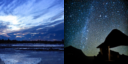

In [23]:
import copy

# To align with training T5 encoding truncation. 
# Probably not necessary.
def get_masked_t5_encodings(t5_encoding):
    num_tokens = int(meta['t5_num_valid_tokens'])
    adjusted_t5_encoding = copy.deepcopy(t5_encoding)
    adjusted_t5_encoding.flags.writeable = True
    adjusted_t5_encoding[num_tokens + 1: ] = adjusted_t5_encoding[num_tokens]
    return adjusted_t5_encoding

batch_size = t5_encoding.shape[0]
full_batch_size = batch_size * 2
image_size = 64
guidance_scale = 8.  # Adjust guidance scale for generated image to be more aligned to text.
repeatations = 1

t5_text_encodings = torch.from_numpy(t5_encoding).cuda()

# Create for the classifier-free guidance (empty)
out_dict = {}
out_dict["text_encodings"] = th.cat(
    [t5_text_encodings, th.zeros_like(t5_text_encodings)], dim=0)

# ALL ZERO
out_dict["clip_emb"] = th.cat(
    [th.zeros((batch_size, 768)), th.zeros((batch_size, 768))], dim=0)

dynamic_thresholding_percentile = None

def model_fn(x_t, ts, **kwargs):
    global guidance_scale
    guidance_scale = guidance_scale
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = unet(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

for idx in range(1, repeatations+1):
    sample = diffusion.p_sample_loop(
        model_fn,
        shape=(full_batch_size, 3, image_size, image_size),
        clip_denoised=True,
        dynamic_threshold=dynamic_thresholding_percentile,
        model_kwargs=out_dict,
        device=device,
        progress=True,
    )

    sample = sample[:batch_size]
    grid = make_grid(sample, nrow=int(
            2), padding=0).cpu()
    image = to_pil_image(grid.add(1).div(2).clamp(0, 1))  # PIL.Image

    captions = [meta["text"] for meta in meta_list]
    print(captions)

    image.show()
    image.save(f'sample_{idx+1}_guidance_{guidance_scale}.png')
    sample = sample.cpu().numpy()
    np.save(f'sample_{idx+1}_guidance_{guidance_scale}.npy', sample)